In [42]:
from model import Model
from dmchunk import Chunk
import math
import statistics
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
discrete_intervals = [1.165, 1.265, 1.395, 1.535, 1.675]  # time intervals to be reproduced in seconds, as used in the real experiment
num_intervals = len(discrete_intervals)  # number of different intervals
num_blocks = 2  # different blocks of experiment
num_trials_per_block = 80  # intervals presented in each block
b1_interval_rep = num_trials_per_block//num_intervals  # number of each interval for 1st block: equal number
b2_general_interval_rep = 12  # number of non-biased intervals for 2nd block
b2_bias_interval_rep = 32  # number of biased interval for 2nd block
b2_a = 1.12  # alpha manipulated explicitly for the 2nd block. Inspired from the work of L. Richard Moore Jr.
condition = [0, 1]  # the two possible bias conditions for the 2nd block. 0: bias towards shortest and 1: bias towards longest interval
num_subjects = 61  # replicating the usable subject sample from the experiment

In [44]:
# helper to add noise to time->pulses and pulses->time
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

# transition from time to pulses (storing)
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    return pulses

# transition from pulses to time (reproduction)
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    return time

# selects and randomly shuffles equal number of instances from each interval (1st block set-up)
def form_first_block_intervals():
    all_intervals = []
    [all_intervals.extend(discrete_intervals) for i in range(b1_interval_rep)]
    random.shuffle(all_intervals)
    return all_intervals
    
# selects and randomly shuffles equal number of instances and biases in favour of shortes or longest interval (2nd block set-up)
def form_second_block_intervals(condition):
    all_intervals = []
    # first add 'b2_general_interval_rep' amount of every interval (12/each = 60 intervals)
    [all_intervals.extend(discrete_intervals) for i in range(b2_general_interval_rep)]
    # then add the remaning 'b2_bias_interval_rep - b2_general_interval_rep' of the appropriate biased interval 
    # (remaining 20 of it only, total 80 intervals)
    if condition == 0:
        all_intervals.extend([discrete_intervals[0] for i in range(b2_bias_interval_rep - b2_general_interval_rep)])
    elif condition == 1:
        all_intervals.extend([discrete_intervals[-1] for i in range(b2_bias_interval_rep - b2_general_interval_rep)])
    else:
        print("** CONDITION OPTION DOESN'T EXIST **")
    # suffle all intervals since they are randomly presented to the subjects on the experiment
    random.shuffle(all_intervals)
    return all_intervals

In [45]:
# implementation of one trial/instance run of the experiment (using 5 discrete memories)
def trial_run(my_model, interval, trial_break, inbetween_break, trial, block):
    # progress model time by trial break
    my_model.time += trial_break
    
    # depending on the block, the subject's internal clock slows down, following the insights of J.H. Wearden
    # and the approach of L. Richard Moore Jr.
    if block == 0:
        tm_pulses = time_to_pulses(interval)
    elif block == 1:
        tm_pulses = time_to_pulses(interval, a=b2_a)
    # form and add chunk to memory
    chunk = Chunk(name="memory_"+str(tm_pulses), slots={"type": "perception", "perceived_pulses": tm_pulses})
    my_model.add_encounter(chunk)
    
    # progress model time by interval
    my_model.time += interval
    # progress model time by brief inbetween break
    my_model.time += inbetween_break
    
    # retrieve (blended) and reproduce interval
    blend_pattern = Chunk(name="blend_pattern", slots={"type": "perception"})
    blended_retrieval, latency = my_model.retrieve_blended_trace(blend_pattern, "perceived_pulses")
    
    # depending on the block, the subject's internal clock slows down. Affects storing and retrieval from DM
    if block == 0:
        reproduced_interval = pulses_to_time(blended_retrieval)
    elif block == 1:
        reproduced_interval = pulses_to_time(blended_retrieval, a=b2_a)
    # progress model time by latency
    my_model.time += latency
    # progress model time by reproduced time
    my_model.time += reproduced_interval
    
    return reproduced_interval

In [46]:
# implementation of a whole block run of the experiment
def block_run(my_model, intervals, block):
    reproduced_block_intervals = []
    # calculate the random duration of breaks between trials 
    trial_breaks = [3 + random.uniform(-0.25, 0.25) for i in range(num_trials_per_block)]
    # calculate the random duration of breaks between the show and reproduce stages of a trial
    inbetween_breaks = [0.8 + random.uniform(-0.1, 0.1) for i in range(num_trials_per_block)] 
    # run for a number of trials corresponding to a block
    for trial in range(num_trials_per_block):
        # store the reproduction
        reproduced_block_intervals.append(
            trial_run(my_model, intervals[trial], trial_breaks[trial], inbetween_breaks[trial], trial, block)
        )
    return reproduced_block_intervals

In [53]:
# implementation of a complete experiment run for a subject
def experiment_run(condition):
    my_model = Model()  # initialize model for every experiment run
    my_model.rt = -5  # reduce threshold
    
    # generate intervals for and run the 1st block
    first_block_intervals = form_first_block_intervals()
    first_block_results = block_run(my_model, first_block_intervals, 0)
    
    # unspecified duration of break between blocks (up to the subjects, based on personal preference during experiment)
    my_model.time += random.uniform(5, 10)
    
    # generate intervals for and run the 2nd block
    second_block_intervals = form_second_block_intervals(condition)
    second_block_results = block_run(my_model, second_block_intervals, 1)
    
    return pd.DataFrame({'Trial': list(range(num_trials_per_block * 2)),
                         'Dur': first_block_intervals + second_block_intervals, 
                         'Rep': first_block_results + second_block_results,
                         'Block': np.zeros(num_trials_per_block, dtype = np.int8).tolist() + np.ones(num_trials_per_block, dtype = np.int8).tolist(),
                         'Cond': [condition] * num_trials_per_block * 2})

In [54]:
# implementation of a complete experiment for all subjects
def experiment():
    results_df = pd.DataFrame(columns=['Trial', 'Dur', 'Rep', 'Block', 'Cond', 'Subj'])  # dataframe to keep all experiment details
    # split subjects into two groups for the two conditions
    # subjects on the short condition
    for subject in range(num_subjects//2):  # 1st half
        short_results = experiment_run(condition[0])
        short_results['Subj'] = [subject+1] * num_trials_per_block * 2
        results_df = results_df.append(short_results)
    # subjects on the long condition
    for subject in range(num_subjects//2, num_subjects): # 2nd half
        long_results = experiment_run(condition[1])
        long_results['Subj'] = [subject+1] * num_trials_per_block * 2
        results_df = results_df.append(long_results)
    return(results_df)

In [55]:
def plot_results(df):
    df = results.copy()

    # mean reproduced intervals by subject
    mean_tp_by_subj = df.groupby(['Dur', 'Block', 'Cond', 'Subj'])['Rep'].mean().reset_index()
    # mean reproduced intervals by duration, block and condition
    mean_tp_by_block = mean_tp_by_subj.groupby(['Dur', 'Block', 'Cond'])['Rep'].mean().reset_index() 
    # mean_tp_by_block&condition
    b1_c1 = mean_tp_by_block[(mean_tp_by_block['Block']==0) & (mean_tp_by_block['Cond']==0)]
    b1_c2 = mean_tp_by_block[(mean_tp_by_block['Block']==0) & (mean_tp_by_block['Cond']==1)]
    b2_c1 = mean_tp_by_block[(mean_tp_by_block['Block']==1) & (mean_tp_by_block['Cond']==0)]
    b2_c2 = mean_tp_by_block[(mean_tp_by_block['Block']==1) & (mean_tp_by_block['Cond']==1)]

    # plotting block results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10), dpi = 300, sharey = True)
    fig.suptitle("Actual vs Reproduced durations", fontsize=18)
    fig.text(0.5, 0.09, 'Actual duration (sec)', fontsize=14, ha='center', va='top')
    ax1.set_title("Long Condition", fontsize=16)
    ax1.plot(b1_c2['Dur'], b1_c2['Rep'], marker = 'o', label = 'Block_1')
    ax1.plot(b2_c2['Dur'], b2_c2['Rep'], marker = 'o', label = 'Block_2')
    ax1.plot((1.2, 1.7), (1.2, 1.7), linestyle = ':')
    ax1.legend()
    ax2.set_title("Short Condition", fontsize=16)
    fig.text(0.09, 0.5, 'Reproduced duation (sec)', fontsize=14, ha='center', va='center', rotation='vertical')
    ax2.plot(b1_c1['Dur'], b1_c1['Rep'], marker = 'o', label = 'Block_1')
    ax2.plot(b2_c1['Dur'], b2_c1['Rep'], marker = 'o', label = 'Block_2')
    ax2.plot((1.2, 1.7), (1.2, 1.7), linestyle = ':')
    ax2.legend()

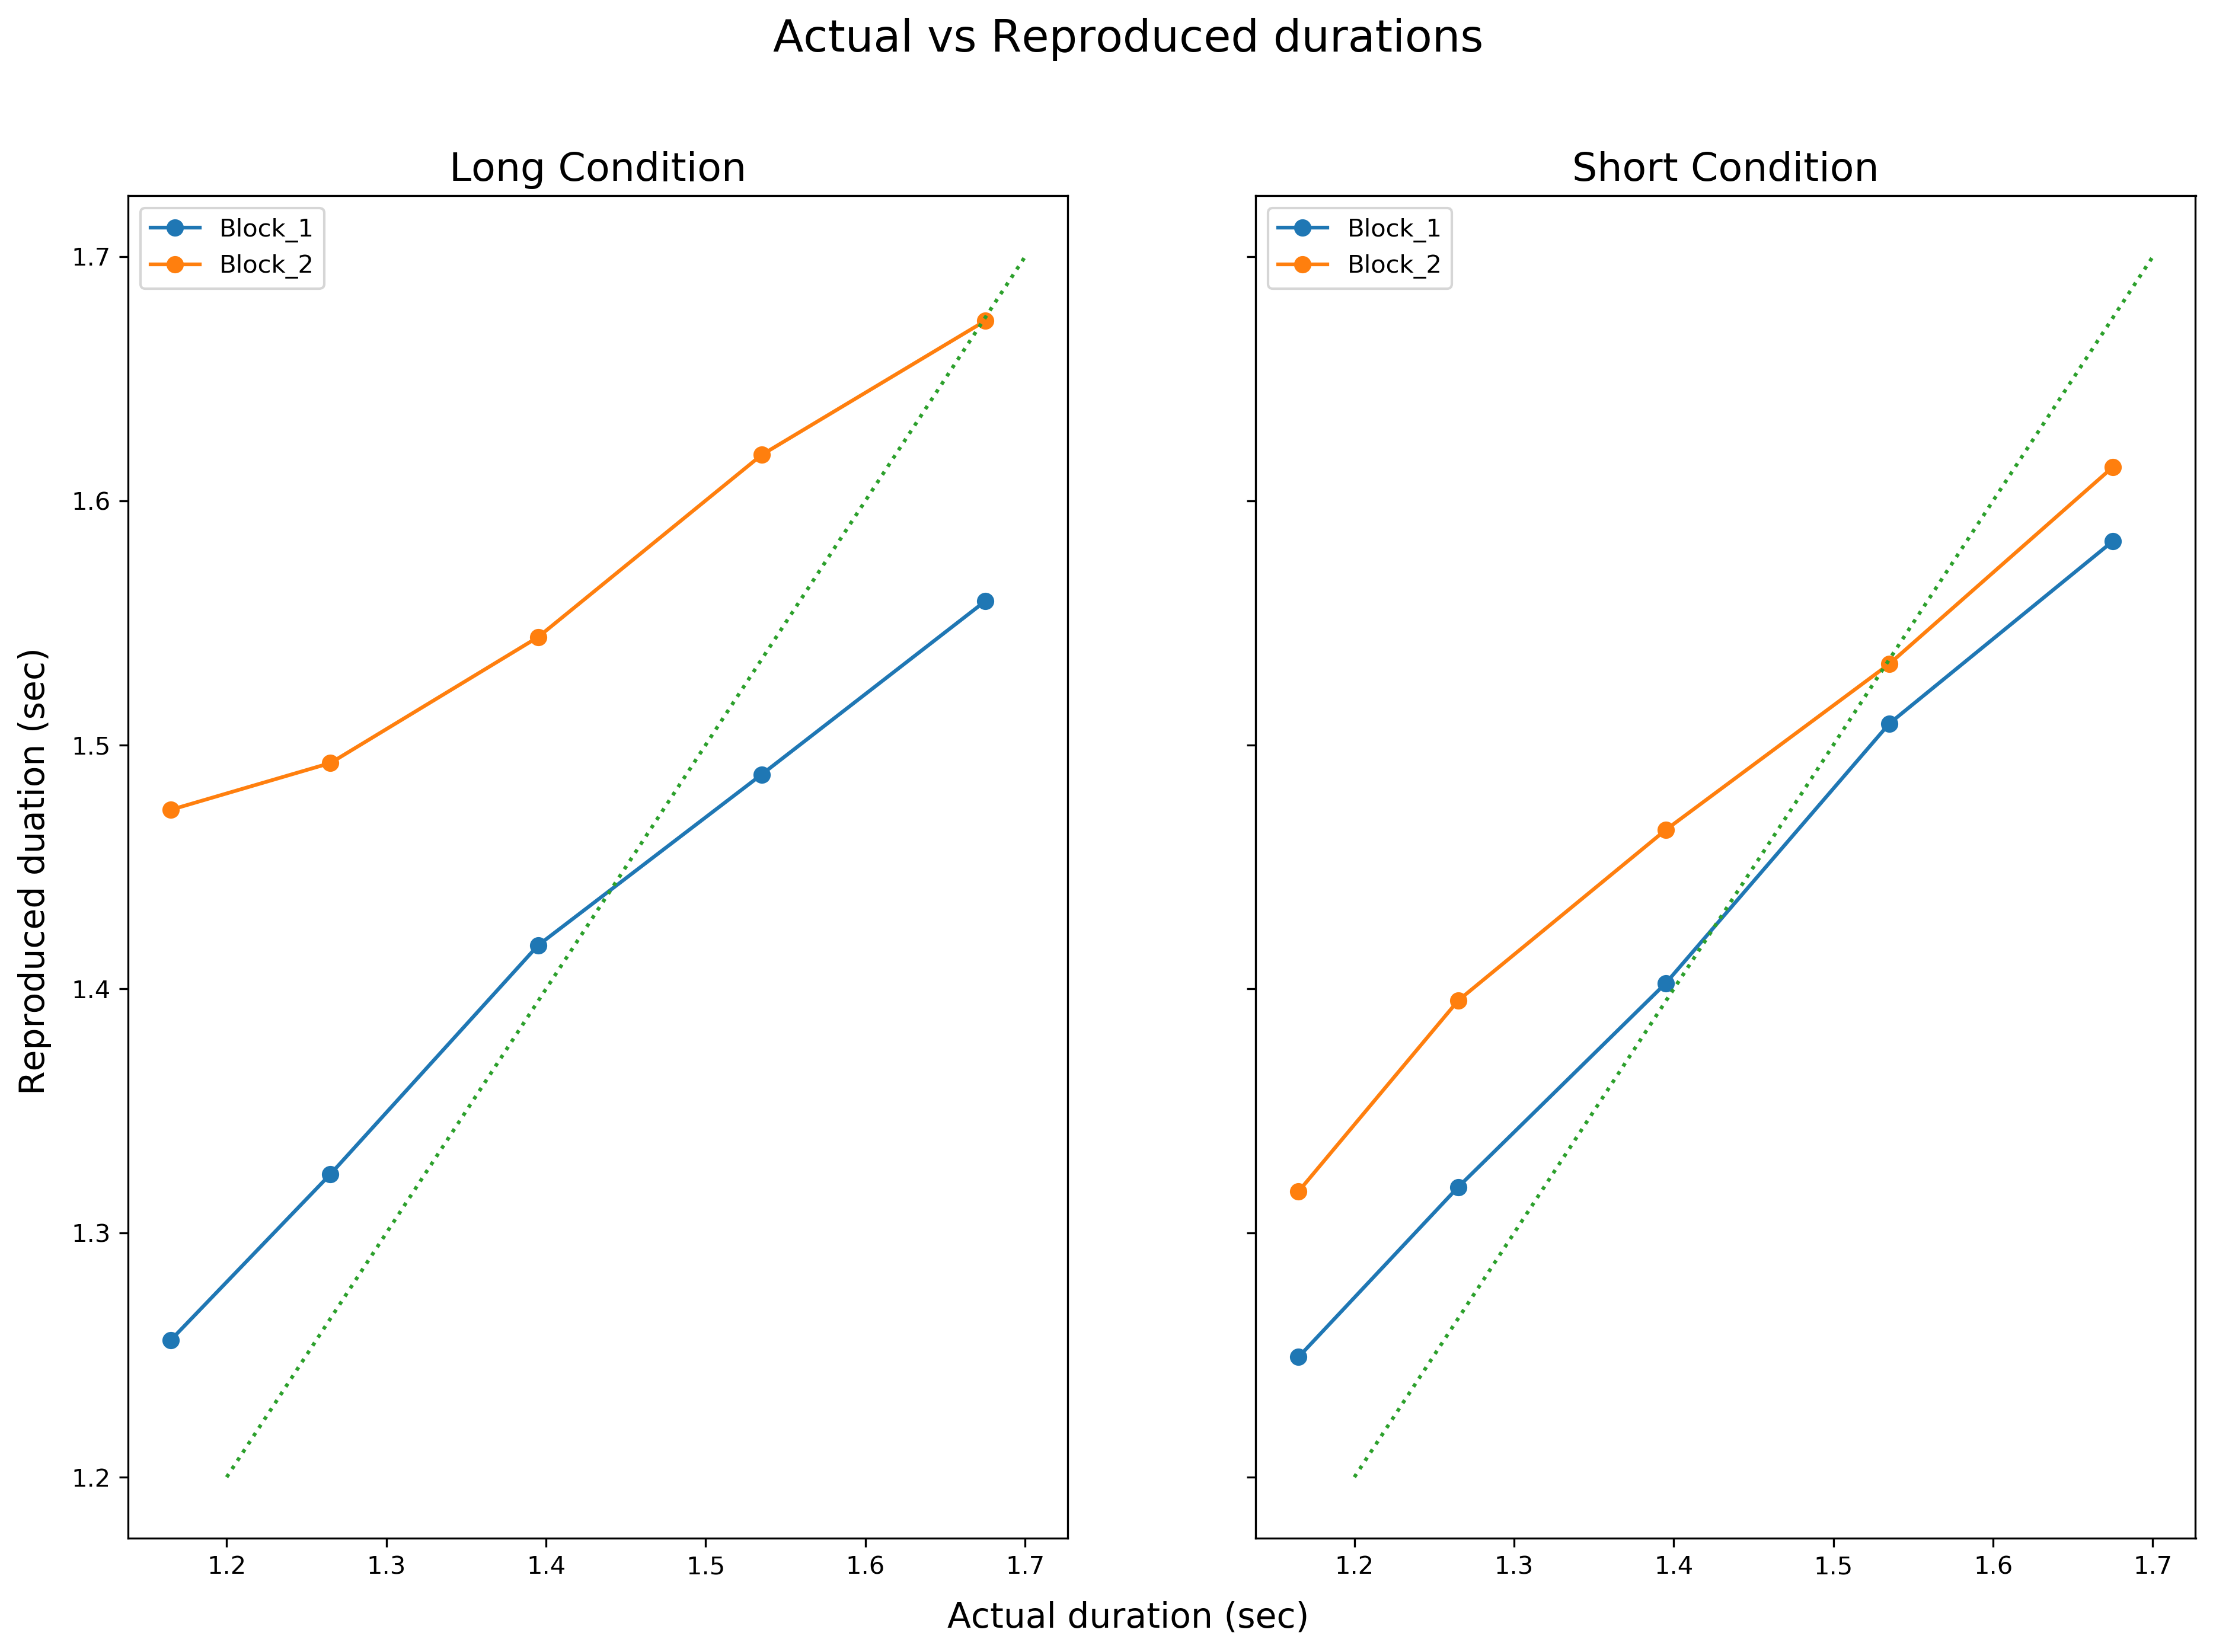

In [57]:
# run experiment with manipulation to model gradual lengthening of responses
results = experiment()
# sample of results
results.head()
# plotting the results of our model
plot_results(results)